# imports

In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa import holtwinters, arima_model
from pandas.tseries.offsets import *
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, GRU, Dropout, Embedding
from pyramid.arima import ARIMA, auto_arima
from math import sqrt
from matplotlib import pyplot
import numpy
import math

In [2]:
import glob
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fbprophet import Prophet
from sklearn import neighbors, ensemble, tree, metrics
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import *
import calendar

%matplotlib notebook

package_dir = os.getcwd()

print(package_dir)

df = pd.DataFrame()

for file in glob.glob('res/*2013_timeseries.csv'):
    # read single file, index on StationEoI and DatetimeEnd
    read = pd.read_csv(file,
                 encoding="utf-16", parse_dates=[13, 14],
                 infer_datetime_format=True,
                 index_col=[14])
    # drop 'bulk' files because they have different averaging
    bulks = read.SamplingPoint.str.lower().str.contains('bulk')
    clean = read[~bulks].copy()
    
    # ignore unnecessary columns
    clean.drop(columns=['Countrycode', 'Namespace', 'AirQualityNetwork',
                 'AirQualityStation', 'SamplingPoint', 'Sample',
                 'SamplingProcess', 'AirPollutantCode',
                 'DatetimeBegin', 'Validity', 'Verification',
                 'AveragingTime'],
        inplace=True)
    
    
    df = pd.concat([df, clean])

# make pollutant a column for better memory usage
df = df.pivot_table(columns='AirPollutant',
                   index=[df.index, 'AirQualityStationEoICode', 'UnitOfMeasurement'],
                   values='Concentration').reset_index(level=[1,2])

# make names shorter    
df.index.names = ['Timestamp']
#df.columns.names = [None, 'Pollutant']

df = df.sort_index()
#df = df.groupby(level=[0]).first()

def create_artificial_features(series, frequency='H', steps=7):
    nondups = series[~series.index.duplicated()]
    lagged = create_lagged_features(nondups, frequency, steps)
    
    statistics = lagged
    statistics['sum'] = lagged.sum(axis=1)
    statistics['mean'] = lagged.mean(axis=1)
    statistics['median'] = lagged.median(axis=1)
    
#    weekdays = pd.get_dummies(lagged.index.weekday_name)
#    weekdays = weekdays.applymap(lambda x: bool(x))
#    weekdays.index = lagged.index
    
#    months = pd.get_dummies(lagged.index.month.map(lambda x: calendar.month_abbr[x]))
#    months = months.applymap(lambda x: bool(x))
#    months.index = lagged.index
    
#    out = statistics.join(weekdays).join(months)
    out = statistics
    
    return out

def create_lagged_features(series, frequency='H', steps=7):
    lagged = pd.DataFrame()


    for i in range(0, steps):
        lagged['lag {}{}'.format(i, frequency)] = series.shift(i, freq=frequency)

    lagged.index = series.index
    lagged = lagged[steps:]

    return lagged.interpolate()

/home/sebastian/Programming/Bachelorthesis


In [65]:
def difference_series(series, stepsize=1):
    diff = list()
    for i in range(stepsize, len(series), stepsize):
        diff.append(series.iloc[i] - series.iloc[i - stepsize])
    out = pd.Series(diff)
    out.index = series.index[stepsize::stepsize]
    return out

def dedifference_series(series, start_level, stepsize=1):
    dediff = list()
    sum = start_level
    for i in range(0, len(series), stepsize):
        sum += series.iloc[i]
        dediff.append(sum)
    out = pd.Series(dediff)
    out.index = series.index
    return out

def scale_series(series):
    X = series.values
    X = X.reshape(len(X), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(X)
    scaled_X = scaler.transform(X)
    scaled_X = scaled_X.reshape(len(scaled_X))
    scaled_series = pd.Series(data=scaled_X, index=series.index)
    return scaled_series, scaler

In [59]:
def _calc_mae(expected, actual):
    mae = 0
    for i in range(0, len(expected)):
        mae += math.fabs(expected.iloc[i] - actual.iloc[i])
    return mae / len(expected)


def _calc_mse(expected, actual):
    mse = 0
    for i in range(0, len(expected)):
        mse += (expected.iloc[i] - actual.iloc[i]) ** 2
    return mse / len(expected)

In [60]:
so2 = df[df.AirQualityStationEoICode == 'DESN025'].SO2.interpolate()
so2 = so2[~so2.index.duplicated(keep='last')]
diff = difference_series(so2)
dediff = dedifference_series(diff, so2.iloc[0])

# GRU

In [6]:
print(so2.head())
print(diff.head())
print(dediff.head())

Timestamp
2013-01-01 00:00:00    27.458
2013-01-01 01:00:00    10.514
2013-01-01 02:00:00     5.561
2013-01-01 03:00:00     4.948
2013-01-01 04:00:00     4.043
Name: SO2, dtype: float64
Timestamp
2013-01-01 01:00:00   -16.944
2013-01-01 02:00:00    -4.953
2013-01-01 03:00:00    -0.613
2013-01-01 04:00:00    -0.905
2013-01-01 05:00:00     0.032
dtype: float64
Timestamp
2013-01-01 01:00:00    10.514
2013-01-01 02:00:00     5.561
2013-01-01 03:00:00     4.948
2013-01-01 04:00:00     4.043
2013-01-01 05:00:00     4.075
dtype: float64


In [64]:
scaled, scaler = scale_series(so2)
artificial = create_artificial_features(scaled, steps=24)

In [53]:
model = Sequential()
model.add(GRU(15, input_shape=(27,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile('rmsprop', loss='mse')

In [54]:
train_length = 0.7

x = artificial.loc[scaled[24:-24].index].values
x_tr = x[:int(len(x)*train_length)]
x_tr = x_tr.reshape(x_tr.shape[0], x_tr.shape[1], 1)

x_te = x[int(len(x)*train_length):]
x_te = x_te.reshape(x_te.shape[0], x_te.shape[1], 1)

y = scaled[48:].values
y_tr = y[:int(len(y)*train_length)]
y_tr = y_tr.reshape(y_tr.shape[0], 1)

y_te = y[int(len(y)*train_length):]
y_te = y_te.reshape(y_te.shape[0], 1)

change_point = scaled[48:].index[int(len(y)*train_length)]


fit = model.fit(x_tr, y_tr, batch_size=24*7, epochs=10)

Epoch 1/10
6076/6076 [==============================] - 1s 241us/step - loss: 0.6111
Epoch 2/10
6076/6076 [==============================] - 1s 103us/step - loss: 0.0547
Epoch 3/10
6076/6076 [==============================] - 1s 96us/step - loss: 0.0420
Epoch 4/10
6076/6076 [==============================] - 1s 101us/step - loss: 0.0365
Epoch 5/10
6076/6076 [==============================] - 1s 101us/step - loss: 0.0349
Epoch 6/10
6076/6076 [==============================] - 1s 97us/step - loss: 0.0312
Epoch 7/10
6076/6076 [==============================] - 1s 101us/step - loss: 0.0306
Epoch 8/10
6076/6076 [==============================] - 1s 96us/step - loss: 0.0291
Epoch 9/10
6076/6076 [==============================] - 1s 100us/step - loss: 0.0286
Epoch 10/10
6076/6076 [==============================] - 1s 100us/step - loss: 0.0283


In [55]:
pred_test = model.predict(x_te)
pred_rescaled = scaler.inverse_transform(pred_test)
pred_rescaled = pd.Series(pred_rescaled.reshape(len(pred_rescaled)))

pred_train = model.predict(x_tr)
pred2_rescaled = scaler.inverse_transform(pred_train)
pred2_rescaled = pd.Series(pred2_rescaled.reshape(len(pred2_rescaled)))

In [56]:
print('Test')
print(_calc_mae(pred_rescaled, so2[change_point:][:len(pred_rescaled)]))
print(_calc_mse(pred_rescaled, so2[change_point:][:len(pred_rescaled)]))
print('\nTrain')
print(_calc_mae(pred2_rescaled, so2[scaled[48:].index[0]:][:len(pred2_rescaled)]))
print(_calc_mse(pred2_rescaled, so2[scaled[48:].index[0]:][:len(pred2_rescaled)]))

Test
1.1735386677006001
3.085869181592099

Train
1.247569422727221
3.998400966046272


<IPython.core.display.Javascript object>


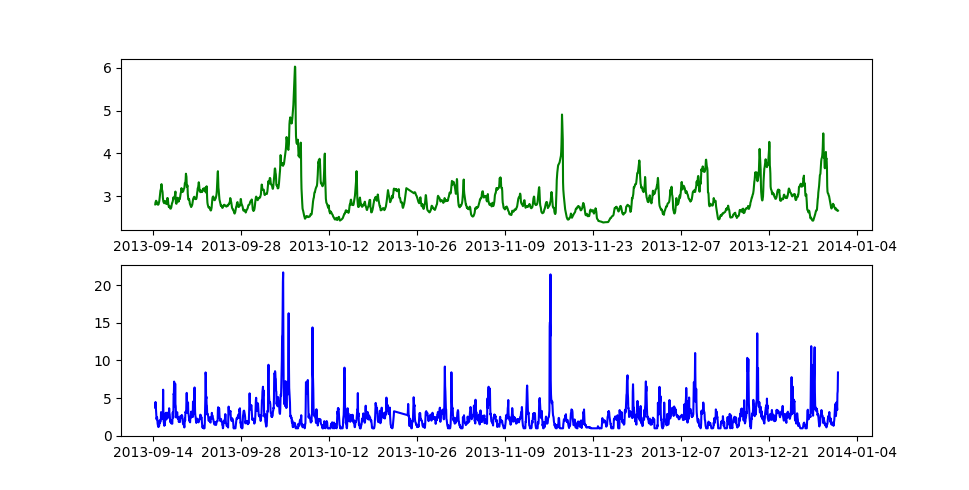

In [57]:
index = so2[change_point:][:len(pred_rescaled)].index
actual = so2[change_point:][:len(pred_rescaled)]

plt.figure(1)
plt.subplot(211)
plt.plot(index, pred_rescaled, 'g')

plt.subplot(212)
plt.plot(index, actual, 'b')

# ETS

In [24]:
ets = holtwinters.ExponentialSmoothing(so2[:200], trend='additive', damped=True,
                                         seasonal='additive', freq='H',
                                       seasonal_periods=24)
fit = ets.fit()
ets2 = holtwinters.ExponentialSmoothing(so2[:200], trend='additive', damped=True,
                                        seasonal='additive', freq='H',
                                        seasonal_periods=24)
fit2 = ets2.fit(use_boxcox=True)

In [36]:
pred1 = fit.predict(so2.index[201], so2.index[251])
pred2 = fit2.predict(so2.index[201], so2.index[251])

In [37]:
for pred in [pred1, pred2]:
    print('mae ' + str(_calc_mae(so2[201:251], pred)))
    print('mse ' + str(_calc_mse(so2[201:251], pred)))

mae 0.741529828432183
mse 1.1477059358858335
mae 0.7239467088680649
mse 1.1477059358858335


# ARIMA

In [27]:
arima_stepwise = auto_arima(so2[:3000], start_p=1, start_q=1, max_p=4, max_q=4,
                          start_P=0, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=5675.344, BIC=5697.747, Fit time=0.342 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=8956.276, BIC=8967.478, Fit time=0.082 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=5688.027, BIC=5704.829, Fit time=0.351 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=7278.965, BIC=7295.768, Fit time=0.273 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=5668.527, BIC=5696.531, Fit time=0.676 seconds
Fit ARIMA: order=(2, 0, 3) seasonal_order=(0, 0, 0, 1); AIC=5670.459, BIC=5709.666, Fit time=3.466 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=6527.421, BIC=6549.824, Fit time=0.596 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=5670.485, BIC=5704.090, Fit time=1.604 seconds
Fit ARIMA: order=(1, 0, 3) seasonal_order=(0, 0, 

In [28]:
pred = arima_stepwise.predict(n_periods=50)
pred_series = pd.Series(pred)

In [31]:
print('mae ' + str(_calc_mae(so2[3001:3051], pred_series)))
print('mse ' + str(_calc_mse(so2[3001:3051], pred_series)))

mae 2.535671133543085
mse 7.743558505141733


In [30]:
arima_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 2000
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -2829.263
Date:                Sat, 11 Aug 2018   AIC                           5668.527
Time:                        21:33:52   BIC                           5696.531
Sample:                             0   HQIC                          5678.810
                               - 2000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3627      0.047      7.776      0.000       0.271       0.454
ar.L1          0.9200      0.004    216.545      0.000       0.912       0.928
ma.L1          0.0819      0.011      7.494      0.000       0.060       0.103
ma.L2         -0.0786      0.014     -5.718      0.000      -0.106      -0.052
sigma2         0.9905      0.008    117.266      0.000       0.974       1.007
===================================================================================
Ljung-Box (Q):                      110.28   Jarque-Bera (JB):            152481.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -0.54
Prob(H) (two-sided):                  0.01   Kurtosis:                        45.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Prophet

In [37]:
pdf = so2[:3000].reset_index()
pdf = pdf.rename(columns={'Timestamp': 'ds', 'SO2': 'y'})

prophet = Prophet()
prophet_fit = prophet.fit(df=pdf)
future = prophet.make_future_dataframe(50)[-50:]

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/usr/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [38]:
pred = prophet.predict(future)

In [39]:
print(len(pred), ' ', len(pdf))

3050   3000


In [40]:
print('mae ' + str(_calc_mae(so2[3000:3050], pred['yhat'])))
print('mse ' + str(_calc_mse(so2[3000:3050], pred['yhat'])))

mae 0.8047518265279892
mse 1.1836808252591968
